# Dark Matter Spectra Reweighted from CRPropa

In [1]:
from __future__ import print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load HDMSpectra
from HDMSpectra import HDMSpectra

import numpy as np
#import scipy as sp
#import scipy.interpolate as interpolate
#import scipy.integrate as integrate
#import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy.stats
from scipy.interpolate import interp1d
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['legend.fontsize'] = 26
mpl.rcParams['legend.frameon'] = False
import seaborn as sns
plt.style.use('/Users/barbaraskrzypek/Documents/IceCube/LVNeutrinos/LV/paper.mplstyle')

## Dark Matter Spectra 

In [2]:
data = '/Users/barbaraskrzypek/Documents/IceCube/EBL/HDMSpectra/data/HDMSpectra.hdf5' # location of hdf5 file

## CRPropa Spectra 

In [3]:
file_galactic_ebl = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_0.1_True_False.txt")

In [4]:
file_galactic_ebl_IC = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_0.1_True_True.txt")

In [17]:
file_galactic_cmb = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_0.1_False_False.txt")

In [ ]:
file_galactic_cmb_IC = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_0.1_False_True.txt")

In [ ]:
file_galacticNoIC_ebl = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_0.1_True_False.txt")

In [ ]:
file_extragalactic_cmb = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_10.0_False.txt")

In [18]:
file_extragalactic_ebl = np.genfromtxt("PhotonSpectra/crpropa_photon_output_PowerLawCosmologicalEvolution_10_10000.0_True.txt")

## Weights 

### Galactic Weights

To get the galactic spectrum weights, we sum over initial photon positions multiplied by the Navarro-Frenk-White DM density profile in the following way: 

$$\frac{d\phi}{dEd\Omega} = \frac{1}{4\pi m_{DM} \tau_{DM}}\frac{dN}{dE_{\gamma}}\sum \Delta s \times \rho^{\text{NFW}}(r(s,l,b)),$$

where the NFW profile is defined as 

$$\rho^{\text{NFW}}(r) = \frac{\rho_s}{r/r_s\big(1+r/r_s\big)^2},$$

with $r_s = 24$ kpc and $\rho_s = 0.18$ GeV/cm$^3$. We propagate galactic photons from 0 to 100 kpc with a cosmological redshift evolution and an initial power law spectrum following 

$$ \phi \propto \Big(\frac{E}{E_c}\Big)^{-1}$$

with $E_c = 10^7$ GeV and $E_{\text{min}} = 100$ GeV. In the function below, we then factorize the weights into two componts:

$$\text{weights} = \text{weights_position}\times \text{weights_energy}$$

where weights_position is the sum over the initial photon distances and weights_energy is the contribution from the dark matter number density, depending on energy, along with the factor of one over the initial photon spectrum and the final energy squared:

$$\text{weights_position} =  \frac{1}{4\pi m_{DM} \tau_{DM}} \sum \Delta r \times \rho(r),$$

$$\text{weights_energy} = \frac{dN_{DM}}{dE_{\gamma}}\Big(\frac{E_i}{E_c}\Big)E_f^2$$

The product of these weights is then applied to the final spectrum from CRPropa:

$$ \text{reweighted spectrum} = \text{weights_position}\times\text{weights_energy}\times \Big(\frac{dN_f}{dE_{\gamma}}\Big)_{\text{CRPropa}}$$

In [5]:
kpcTocm = 3.086*10**21
rs = 24 #in kpc 
R = 8.5 #in kpc 
phi = np.linspace(0,2*np.pi,32)
def weights_galactic(r,mDM,tauDM):
    c = (1/(4*(np.pi)*mDM*tauDM))
    R_array = R*np.ones(len(phi)-1)
    r_array = r*np.ones(len(phi)-1)
    radial = (1/(2*np.pi))*np.sum(np.sqrt(r**2+R**2-2*r*R*np.cos(phi))) #galactic coordinate in kpc 
    f = 0.18/((radial/rs)*(1+radial/rs)**2)
    rho = c*f
    return rho

In [6]:
weights_galactic(10,10**6,10**28)

4.872522159452853e-38

### Extragalactic weights

To obtain the extragalactic weights, we similarly sum over initial photon positions starting from 100 kpc. The spectra are calculated in the following way: 

$$ \frac{d\phi}{dE d\Omega} = \frac{\Omega_{DM}\rho_c}{4\pi m_{DM}\tau_{DM}}\sum \Delta z \frac{1}{H(z)}\frac{dN}{dE^{\prime}}$$

where the critical energy density $\rho_c = 5.5\times 10^{-6}$ GeV/cm$^3$ and $E^{\prime} = E(1+z).$ We start with the same power-law spectrum shown above, with the exception that we propagate over distances of 100 kpc to 10 Mpc. We then facrorize the weights in a similar way to the galactic case: 

$$\text{weights} = \text{weights_position}\times \text{weights_energy}$$

where weights_position is the sum over the initial photon redshifts and weights_energy is the contribution from the dark matter number density, depending on energy, along with the factor of one over the initial photon spectrum and the final energy squared:

$$ \text{weights_position} =  \frac{\Omega_{DM}\rho_c}{4\pi m_{DM}\tau_{DM}}\sum \Delta z \frac{1}{H(z)(1+z)}$$

$$ \text{weights_energy} = \frac{dN_{DM}}{dE_{\gamma}}\Big(\frac{E_i}{E_c}\Big)E_f^2$$

The product of these weights is then applied to the final spectrum from CRPropa:

$$ \text{reweighted spectrum} = \text{weights_position}\times\text{weights_energy}\times \Big(\frac{dN_f}{dE_{\gamma}}\Big)_{\text{CRPropa}}$$

In [7]:
rho_c = 5.5*10**(-6) #in units GeV/cm^3
omega_DM = 0.23
omega_m = 0.27
c = 3*10**5 #in km/s
H0 = 67.7 #in (km/s)/(Mpc)
def H(z):
    h = np.sqrt(omega_m*(1+z)**3+(1-omega_m))
    return h
def weights_extragalactic(r,mDM,tauDM): 
    a = (1/(4*(np.pi)*mDM*tauDM)) 
    z = (H0*r/c)*10**(-3) #converts distance in kpc to redshift 
    f = (1+z)/(H0*H(z)) 
    return a*f

In [8]:
weights_extragalactic(1000,10**6,10**28)

1.17560050605971e-37

In [9]:
dR_galactic = (0.1-0.001)/1000
dR_galactic

9.900000000000001e-05

In [82]:
np.histogram(np.array([xx[3] for xx in file_galactic_ebl if (xx[2] == 22 and xx[5]<=10**-3)])*10**9*10**-6)[1]

array([1.000000e-04, 9.975180e-02, 1.994036e-01, 2.990554e-01,
       3.987072e-01, 4.983590e-01, 5.980108e-01, 6.976626e-01,
       7.973144e-01, 8.969662e-01, 9.966180e-01])

In [27]:
HDMSpectra.spec(22,5, 10*2/10**6, 10**6, data)

array([1488324.65616083])

In [22]:
data

'/Users/barbaraskrzypek/Documents/IceCube/EBL/HDMSpectra/data/HDMSpectra.hdf5'

In [ ]:
class Event: 
    def self.__init__(E0,Z0,[E1,Z1],[E,Z]):
        

## Make Weights 

In [9]:
def MakeGalacticWeights(file_galactic,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
        
    #Photon Energies 
    
    total_events_galactic = np.unique(np.array([xx[5] for xx in file_galactic]))
    
    photo_energies_initial = np.array([xx[5] for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])
    photo_energies_final = np.array([xx[3] for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])
    photo_positions_initial = np.array([xx[6] for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])
    
    #DM Spectrum 
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,30) # Energy values
    R_galactic = np.linspace(0.001,0.1,1000) #initial galactic positions in Mpc
    R_extragalactic = np.linspace(0.1,10000,1000) #initial extragalactic positions in Mpc
    dR_galactic = (0.1-0.001)/1000
    dR_extragalactic = (10000-0.1)/1000
    
    #energy binning 
    
    lEbins = np.logspace(1,6,30) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
    
    # Extract & reweight the spectrum using HDMSpectra.spec
    dNdx = HDMSpectra.spec(finalstate, initialstate, x*2/mDM, mDM, data)
    spectrum = dNdx*(2/mDM)
    
    #weights
    photo_energies_initial *= 10**9
    photo_energies_final *= 10**9
    weights_r = np.ones_like(photo_energies_final)
    for i in range(len(R_galactic) - 1):
        r = (R_galactic[i]+R_galactic[i+1])/2 #takes the midpoint of each bin
        r *= 10e3
        delta_r = R_galactic[i+1]-R_galactic[i]
        delta_r *= 10e3 #convert Mpc to kpc
        #boolean array that selects the events in a given bin
        bin_bool = (photo_positions_initial >= R_galactic[i]) & (photo_positions_initial < R_galactic[i+1])
        #
        photo_positions_initial_bin = photo_positions_initial[bin_bool]
        photo_energies_final_bin = photo_energies_final[bin_bool]
        weights_final_bin = np.ones_like(photo_energies_final_bin)*weights_galactic(r,mDM,10**28)*delta_r*kpcTocm
        weights_r[bin_bool] = weights_final_bin
        
    weights_energies = np.ones_like(photo_energies_final)
    dNdx_galactic = HDMSpectra.spec(finalstate, initialstate, photo_energies_final*2/mDM, mDM, data)[0]
    spectrum_galactic = dNdx_galactic*(2/mDM)
    weights_energies = spectrum_galactic*photo_energies_initial/(10**7)
    
    weights_final_galactic = weights_r*weights_energies/len(total_events_galactic)
    
    return weights_r,weights_energies,weights_final_galactic

In [10]:
def MakeExtragalacticWeights(file_extragalactic,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
        
    #Photon Energies 
    
    total_events_extragalactic = np.unique(np.array([xx[5] for xx in file_extragalactic]))
    
    photoEG_energies_initial = np.array([xx[5] for xx in file_extragalactic if (xx[2] == 22 and xx[5]<=10**-3)])
    photoEG_energies_final = np.array([xx[3] for xx in file_extragalactic if (xx[2] == 22 and xx[5]<=10**-3)])
    photoEG_positions_initial = np.array([xx[6] for xx in file_extragalactic if (xx[2] == 22 and xx[5]<=10**-3)])
    
    #DM Spectrum 
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,30) # Energy values
    R_galactic = np.linspace(0.001,0.1,1000) #initial galactic positions in Mpc
    R_extragalactic = np.linspace(0.1,10000,1000) #initial extragalactic positions in Mpc
    dR_galactic = (0.1-0.001)/1000
    dR_extragalactic = (10000-0.1)/1000
    
    #energy binning 
    
    lEbins = np.logspace(1,6,30) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
    
    # Extract & reweight the spectrum using HDMSpectra.spec
    dNdx = HDMSpectra.spec(finalstate, initialstate, x*2/mDM, mDM, data)
    spectrum = dNdx*(2/mDM)
    
    
    weightsEG_r = np.ones_like(photoEG_energies_final)
    photoEG_energies_initial *= 10**9
    photoEG_energies_final *= 10**9
    for i in range(len(R_extragalactic) - 1):
        r = (R_extragalactic[i]+R_extragalactic[i+1])/2
        r *= 10e3 #converts Mpc to kpc
        delta_r = R_extragalactic[i+1]-R_extragalactic[i]
        delta_r *= H0/c #converts Mpc to redshift 
        #boolean array that selects the events in a given bin
        bin_bool = (photoEG_positions_initial >= R_extragalactic[i]) & (photoEG_positions_initial < R_extragalactic[i+1])
        #
        photo_positions_initial_bin = photoEG_positions_initial[bin_bool]
        photo_energies_final_bin = photoEG_energies_final[bin_bool]
        weights_final_bin = np.ones_like(photo_energies_final_bin)*weights_extragalactic(r,mDM,10**28)*delta_r
        weightsEG_r[bin_bool] = weights_final_bin
        
    weightsEG_energies = np.ones_like(photoEG_energies_final)
    dNdx_extragalactic = HDMSpectra.spec(finalstate, initialstate, photoEG_energies_final*2/mDM, mDM, data)[0]
    spectrum_extragalactic = dNdx_extragalactic*(2/mDM)
    weightsEG_energies = spectrum_extragalactic*photoEG_energies_initial/(10**7)
    
    weights_final_extragalactic = weightsEG_r*weightsEG_energies/len(total_events_extragalactic)
    
    return weightsEG_r,weightsEG_energies,weights_final_extragalctic

In [11]:
def MakeWeights(file_galactic,file_extragalactic,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
        
    #Photon Energies 
    
    total_events_galactic = np.unique(np.array([xx[5] for xx in file_galactic]))
    total_events_extragalactic = np.unique(np.array([xx[5] for xx in file_extragalactic]))
    
    photo_energies_initial = np.array([xx[5] for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])
    photo_energies_final = np.array([xx[3] for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])
    photo_positions_initial = np.array([xx[6] for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])
    
    photoEG_energies_initial = np.array([xx[5] for xx in file_extragalactic if (xx[2] == 22 and xx[5]<=10**-3)])
    photoEG_energies_final = np.array([xx[3] for xx in file_extragalactic if (xx[2] == 22 and xx[5]<=10**-3)])
    photoEG_positions_initial = np.array([xx[6] for xx in file_extragalactic if (xx[2] == 22 and xx[5]<=10**-3)])
    
    #DM Spectrum 
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,30) # Energy values
    R_galactic = np.linspace(0.001,0.1,1000) #initial galactic positions in Mpc
    R_extragalactic = np.linspace(0.1,10000,1000) #initial extragalactic positions in Mpc
    dR_galactic = (0.1-0.001)/1000
    dR_extragalactic = (10000-0.1)/1000
    
    #energy binning 
    
    lEbins = np.logspace(1,6,30) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
    
    # Extract & reweight the spectrum using HDMSpectra.spec
    dNdx = HDMSpectra.spec(finalstate, initialstate, x*2/mDM, mDM, data)
    spectrum = dNdx*(2/mDM)
    
    #weights
    photo_energies_initial *= 10**9
    photo_energies_final *= 10**9
    weights_r = np.ones_like(photo_energies_final)
    for i in range(len(R_galactic) - 1):
        r = (R_galactic[i]+R_galactic[i+1])/2 #takes the midpoint of each bin
        r *= 10e3
        delta_r = R_galactic[i+1]-R_galactic[i]
        delta_r *= 10e3 #convert Mpc to kpc
        #boolean array that selects the events in a given bin
        bin_bool = (photo_positions_initial >= R_galactic[i]) & (photo_positions_initial < R_galactic[i+1])
        #
        photo_positions_initial_bin = photo_positions_initial[bin_bool]
        photo_energies_final_bin = photo_energies_final[bin_bool]
        weights_final_bin = np.ones_like(photo_energies_final_bin)*weights_galactic(r,mDM,10**28)*delta_r*kpcTocm
        weights_r[bin_bool] = weights_final_bin
    
    weightsEG_r = np.ones_like(photoEG_energies_final)
    photoEG_energies_initial *= 10**9
    photoEG_energies_final *= 10**9
    for i in range(len(R_extragalactic) - 1):
        r = (R_extragalactic[i]+R_extragalactic[i+1])/2
        r *= 10e3 #converts Mpc to kpc
        delta_r = R_extragalactic[i+1]-R_extragalactic[i]
        delta_r *= H0/c #converts Mpc to redshift 
        #boolean array that selects the events in a given bin
        bin_bool = (photoEG_positions_initial >= R_extragalactic[i]) & (photoEG_positions_initial < R_extragalactic[i+1])
        #
        photo_positions_initial_bin = photoEG_positions_initial[bin_bool]
        photo_energies_final_bin = photoEG_energies_final[bin_bool]
        weights_final_bin = np.ones_like(photo_energies_final_bin)*weights_extragalactic(r,mDM,10**28)*delta_r
        weightsEG_r[bin_bool] = weights_final_bin
        
    weights_energies = np.ones_like(photo_energies_final)
    dNdx_galactic = HDMSpectra.spec(finalstate, initialstate, photo_energies_final*2/mDM, mDM, data)[0]
    spectrum_galactic = dNdx_galactic*(2/mDM)
    weights_energies = spectrum_galactic*photo_energies_initial/(10**7)
    #for i in range(len(lEcens) - 1):
        #boolean array that selects the events in a given bin
    #    bin_bool = (photo_energies_final >= lEcens[i]) & (photo_energies_final < lEcens[i+1])
        #
    #    photo_energies_final_bin = photo_energies_final[bin_bool]
    #    photo_energies_initial_bin = photo_energies_initial[bin_bool]
    #    weights_final_bin = np.ones_like(photo_energies_final_bin)*(spectrum[i])*((photo_energies_initial_bin/(10**7))**(1))
    #    weights_energies[bin_bool] = weights_final_bin
        
    weightsEG_energies = np.ones_like(photoEG_energies_final)
    dNdx_extragalactic = HDMSpectra.spec(finalstate, initialstate, photoEG_energies_final*2/mDM, mDM, data)[0]
    spectrum_extragalactic = dNdx_extragalactic*(2/mDM)
    weightsEG_energies = spectrum_extragalactic*photoEG_energies_initial/(10**7)
    #for i in range(len(lEcens) - 1):
        #boolean array that selects the events in a given bin
    #    bin_bool = (photoEG_energies_final >= lEcens[i]) & (photoEG_energies_final < lEcens[i+1])
        #
    #    photo_energies_final_bin = photoEG_energies_final[bin_bool]
    #    photo_energies_initial_bin = photoEG_energies_initial[bin_bool]
    #    weightsEG_final_bin = np.ones_like(photo_energies_final_bin)*(spectrum[i])*((photo_energies_initial_bin/(10**7))**(1))
    #    weightsEG_energies[bin_bool] = weightsEG_final_bin
        
    
    weights_final_galactic = weights_r*weights_energies/len(total_events_galactic)
    weights_final_extragalactic = weightsEG_r*weightsEG_energies/len(total_events_extragalactic)
    
    return weights_r,weightsEG_r,weights_energies,weightsEG_energies,weights_final_galactic,weights_final_extragalactic;

## Plots 

### Initial & Attenuated Spectra from CRPropa

In [13]:
lEbins

NameError: name 'lEbins' is not defined

In [14]:
lEbins = np.logspace(2,6,40)
dE = lEbins[1:] - lEbins[:-1]
dE

array([2.66380173e+01, 3.37338570e+01, 4.27198877e+01, 5.40996188e+01,
       6.85106847e+01, 8.67605727e+01, 1.09871869e+02, 1.39139557e+02,
       1.76203576e+02, 2.23140715e+02, 2.82580977e+02, 3.57854947e+02,
       4.53180410e+02, 5.73898686e+02, 7.26773918e+02, 9.20372080e+02,
       1.16554095e+03, 1.47601796e+03, 1.86919988e+03, 2.36711766e+03,
       2.99767088e+03, 3.79619097e+03, 4.80742097e+03, 6.08802261e+03,
       7.70975112e+03, 9.76347597e+03, 1.23642724e+04, 1.56578694e+04,
       1.98288154e+04, 2.51108187e+04, 3.17998429e+04, 4.02706906e+04,
       5.09980041e+04, 6.45828613e+04, 8.17864551e+04, 1.03572745e+05,
       1.31162471e+05, 1.66101553e+05, 2.10347713e+05])

In [15]:
#makes a plot showing the initial and attenuated spectra from CRPropa

def MakeInjPlot(file,file2,gamma,irb = True,extrgalactic = True): 
    
    if irb == True: 
        string = "CMB and IRB"
    else: string = "CMB Only"
    
    #energies
    
    photo_energies_initial = np.unique(np.array([xx[5] for xx in file]))
    photo_energies_initial_all = np.array([xx[5] for xx in file])
    photo_energies_final = np.array([xx[3] for xx in file if xx[2] == 22])
    photo_energies_prompt = np.array([xx[3] for xx in file if ((xx[2]==22) and (xx[3]==xx[5]))])
    photo_energies_secondary = np.array([xx[3] for xx in file if ((xx[2]==22) and (xx[3]!=xx[5]))])
    
    photo_energies_IC = np.array([xx[3] for xx in file2 if xx[2] == 22])
    
    electron_energies_initial = np.unique(np.array([xx[5] for xx in file2]))
    
    print(np.shape(photo_energies_secondary))
    print(np.shape(electron_energies_initial))
    
    #energy binning: 
    
    lEbins = np.logspace(2,6,40) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
    
    Ebins =  np.linspace(1e2,1e6,100)
    Ecens = (Ebins[1:] + Ebins[:-1]) / 2
    dE_lin = Ebins[1:] - Ebins[:-1]
    
    #integral check:
    
    #dE_hist = np.histogram(Ecens,bins = Ebins, weights = dE_lin)[0]
    
    hist_initial = np.histogram(photo_energies_initial*10**9, bins=Ebins,weights = (photo_energies_initial*10**9))[0]/dE_lin
    hist_prompt = np.histogram(photo_energies_prompt*10**9,bins = Ebins, weights = (photo_energies_prompt*10**9))[0]/dE_lin
    hist_secondary = np.histogram(photo_energies_secondary*10**9,bins = Ebins, weights = (photo_energies_secondary*10**9))[0]/dE_lin

    #ratio_initial = hist_initial/dE_hist
    #ratio_prompt = hist_prompt/dE_hist
    #ratio_secondary = hist_secondary/dE_hist
    
    #integrand_initial = np.histogram(Ecens,bins = Ebins,weights = ratio_initial)
    #integrand_prompt = np.histogram(Ecens,bins = Ebins, weights = ratio_prompt)
    #integrand_secondary = np.histogram(Ecens, bins = Ebins, weights = ratio_secondary)
    
    #hist_dist_initial = scipy.stats.rv_histogram(integrand_initial)
    #hist_dist_prompt = scipy.stats.rv_histogram(integrand_prompt)
    #hist_dist_secondary = scipy.stats.rv_histogram(integrand_secondary) 
    
    #integral_initial = hist_dist_initial.cdf(np.max(photo_energies_initial*10**9))
    #integral_prompt = hist_dist_prompt.cdf(np.max(photo_energies_prompt*10**9))
    #integral_secondary = hist_dist_secondary.cdf(np.max(photo_energies_secondary*10**9))
    
    integral_initial = np.sum(hist_initial)
    integral_prompt = np.sum(hist_prompt)
    integral_secondary = np.sum(hist_secondary)
    
    print("Total energy conservation check:")
    print("Total primary energy = " + f'{integral_initial}')
    print("Prompt energy + Secondary energy = " + f'{integral_prompt+integral_secondary}')
    
    # calculate spectrum: J(E) = dN/dE
    
    J_initial = np.histogram(photo_energies_initial*10**9, bins=lEbins,weights = (photo_energies_initial*10**9)**2)[0]/ dE
    J_final = np.histogram(photo_energies_final*10**(9), bins=lEbins,weights = (photo_energies_final*10**9)**2)[0] / dE
    J_prompt = np.histogram(photo_energies_prompt*10**9,bins = lEbins, weights = (photo_energies_prompt*10**9)**2)[0] / dE
    J_secondary = np.histogram(photo_energies_secondary*10**9,bins = lEbins, weights = (photo_energies_secondary*10**9)**2)[0] / dE
    
    J_IC = np.histogram(photo_energies_IC*10**9,bins = lEbins, weights = (photo_energies_IC*10**9)**2)[0] / dE
    
    J_electrons = np.histogram(electron_energies_initial*10**9,bins = lEbins, weights = (electron_energies_initial*10**9)**2)[0] / dE
    
    # make the figure 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    cm2 = mpl.pyplot.get_cmap('Blues')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(14-1)+color_min) for i in range(14)]
    colors2 = [cm2(color_range*i/(14-1)+color_min) for i in range(14)]
    
    plt.hist(lEcens,weights = J_initial,bins = np.logspace(2,6,40),histtype="step", lw = 2, density = False, color = colors[4],label = r"$\gamma =$ {gamma} Initial".format(gamma = gamma))
    plt.hist(lEcens,weights = J_electrons,bins = np.logspace(2,6,40),histtype="step", lw = 2, density = False, color = colors2[6],label = r"$\gamma =$ {gamma} Initial (electrons)".format(gamma = gamma),ls = '--')
    plt.hist(lEcens,weights = J_prompt,bins = np.logspace(2,6,40),histtype="step", lw = 2, density = False, color = colors[8],label = r"$\gamma =$ {gamma} Prompt".format(gamma = gamma),ls = '--')
    plt.hist(lEcens,weights = J_secondary,bins = np.logspace(2,6,40),histtype = "step",lw = 2,density = False, color = colors[10],label = r"$\gamma = ${gamma} Secondary".format(gamma = gamma))
    plt.hist(lEcens,weights = J_IC,bins = np.logspace(2,6,40),histtype = "step",lw = 2,density = False, color = colors2[12],label = r"$\gamma = ${gamma} IC".format(gamma = gamma))
    #plt.hist(photo_energies_initial*10**(9), bins = np.logspace(2,6,40),
    #plt.hist(photo_energies_initial*10**(9), bins = np.logspace(2,6,40),
    #         histtype="step", lw = 2, density = True, color = colors[3],label = r"$\gamma =$ {gamma} initial".format(gamma = gamma),weights = (photo_energies_initial*10**9)**2)
    #y = np.histogram(photo_energies_original*10**(9), bins = np.logspace(2,6,36), density = False, weights = photo_energies_original*10**9**2)
    #plt.hist(photo_energies_final*10**9, bins = np.logspace(2,6,40),
    #         histtype="step", lw = 2, density = True, color = colors[5],label = r"$\gamma =$ {gamma} (final)".format(gamma = gamma),weights = (photo_energies_final*10**9)**2)

    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    plt.semilogy()
    plt.semilogx()
    plt.xlim(1e2,1e7)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"$E^2 dN/dE$",fontsize = 16)
    plt.title(string,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/PowerLawSpectraInj_{gamma1}.pdf".format(gamma1=extrgalactic),dpi = 400,bbox_inches = "tight")
    
    #return rw

(778901,)
(5852,)
Total energy conservation check:
Total primary energy = 71059.69304019804
Prompt energy + Secondary energy = 149053.53049584158


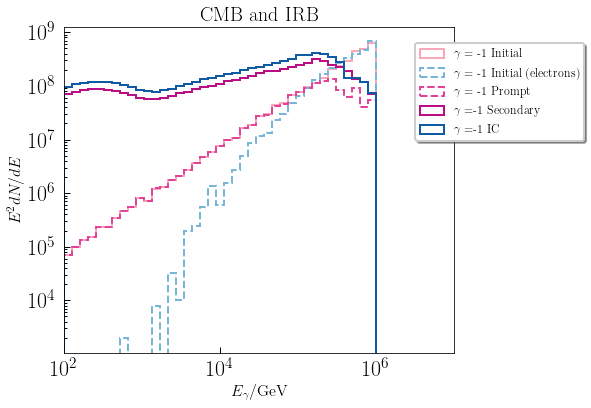

In [16]:
MakeInjPlot(file_galactic_ebl,file_galactic_ebl_IC,-1,True,False)

(4380254,)
(5852,)
Total energy conservation check:
Total primary energy = 6893.498779108912
Prompt energy + Secondary energy = 108674.2661680198


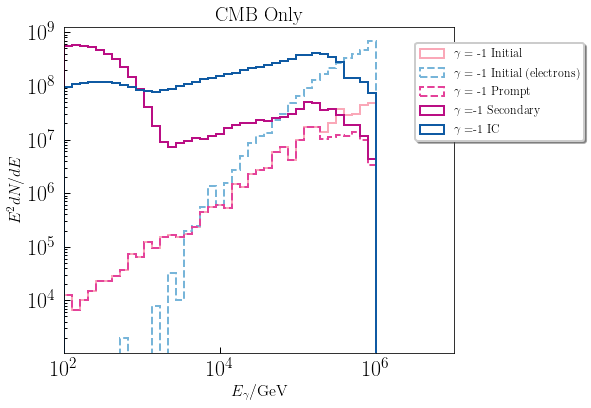

In [18]:
MakeInjPlot(file_galactic_cmb,file_galactic_ebl_IC,-1,False,False)

In [8]:
def Make2DPowerLawPlot(file,gamma,irb = True):
    plt.figure(figsize=(7,6))

    xedges = np.logspace(2,6,36)
    yedges = np.logspace(2,6,36)
    
    lEbins = np.logspace(2,6,25) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dEs = lEbins[1:] - lEbins[:-1] #bin widths 

    photo_energies_initial = np.array([xx[5] for xx in file if xx[2] == 22])
    photo_energies_final = np.array([xx[3] for xx in file if xx[2] == 22])
    
    # calculate spectrum: J(E) = dN/dE
    
    #J_initial = np.histogram(photo_energies_initial*10**9, bins=lEbins)[0]/ dEs
    #J_final = np.histogram(photo_energies_final*10**(9), bins=lEbins)[0] / dEs
    
    #weights_final = np.hstack([J_final*(lEcens)**2]*100) 
    #weights_initial = np.hstack([[ee for _ in range(100)] for ee in J_initial*(lEcens)**2])    

    weights_initial = np.zeros_like(photo_energies_initial)
    photo_energies_initial *= 10**9
    photo_energies_final *= 10**9
    #print(lEbins)
    for i in range(len(lEbins) - 1):
        #print(photo_energies_initial < lEbins[i+1])
        bin_bool = (photo_energies_initial >= lEbins[i]) & (photo_energies_initial < lEbins[i+1])
        #print(bin_bool.sum())
        photo_energies_initial_bin = photo_energies_initial[bin_bool]
        weights_initial_bin = np.ones_like(photo_energies_initial_bin)/ len(photo_energies_initial_bin)
        weights_initial[bin_bool] = weights_initial_bin
        #print(weights_initial.sum())  
     
    fig, ax = plt.subplots()
    
    #print(np.shape(photo_energies_initial))
    h = np.histogram2d(photo_energies_initial,photo_energies_final,bins = [lEbins,lEbins])#, density=True)
    
    im = ax.imshow(h[0],extent = [4,6,2,6],aspect = 'auto',cmap = 'RdPu')
    #fig, ax = plt.subplots()
    
    #im = ax.imshow(hist[0],extent = [1e2,1e6,1e2,1e6],aspect = 'auto', cmap = "RdPu")
    
    e_tick_locs = [2,3,4,5,6]
    e_tick_labs = [r'$10^{%d}$' % exp for exp in e_tick_locs]
    ax.set_yticks(e_tick_locs)
    ax.set_yticklabels(e_tick_labs)
    
    #cbar_tick_locs = [5,6,7,8]
    #cbar_tick_labs = [r'$10^{%d}$' % exp for exp in cbar_tick_locs]
    cbar = fig.colorbar(im,
                    label=r'$N_{\rm{event}}$'
                   )
    #cbar.ax.set_yticklabels(cbar_tick_labs)
    

    #plt.semilogx()
    #plt.semilogy()
    #plt.xlim(1e4,1e6)
    #if(irb):
    #    plt.ylim(1e2,1e6)
    #else:
    #    plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_{\gamma,initial}$/GeV")
    plt.ylabel(r"$E_{\gamma,final}$/GeV")

    #cbar = plt.colorbar()
    #plt.clim(0.0,0.01)
    cbar.set_label(r"dN/dE")
    plt.title("Power Law Spectrum with $\gamma =$ {gamma}, EBL = {irb}".format(gamma = gamma,irb = irb),fontsize = 16)
    plt.savefig("/Users/barbaraskrzypek/Documents/PowerLawSpectrum2d_{irb}_{gamma}.pdf".format(irb = irb,gamma=-gamma*10),dpi = 400,bbox_inches = "tight")
    plt.show()

### Fermi-LAT and IceCube data 

In [68]:
# FERMI PART
fermi = np.genfromtxt("./modelA_integrated_fluxes.txt")
e_fermi_GeV = (fermi[:,0] + fermi[:,1])*1.0e-3/2.
upper_limits = [False]*len(e_fermi_GeV)

In [69]:
bins = np.logspace(np.log10(19952.6), np.log10(3.16228e8), 14) 
bins = bins[1:9]
enu = np.logspace(np.log10(bins[0]), 8, 500)
# Plot the segmented powerlaw flux
def flux(energy, norm, index=2.):
    energyIn100TeV = energy/1e5
    return norm*1e-18*(energyIn100TeV)**(-index)
xmin = bins[0]
xmax = bins[-1]
energy_centers = np.power(10, (lambda x: (x[:-1]+x[1:])/2.)(np.log10(bins)))
intervals = np.array([(0.0, 143.54622664666903, 500.0), (0.0, 2.123691768833845, 5.635437314697244), (4.948055179047638, 6.382657005897758, 8.002066239102458), (0.0, 0.5177890921151547, 1.553873383727041), (0.0, 0.2634178446276476, 1.1728578975033623), (0.9183994046204971, 1.8237591302698424, 3.046362634593988), (0.0, 0.486221306109142, 1.570990230774263), (0.0, 0.0, 0.1869868977346414), (0.0, 0.0, 1.6417124479048653), (0.0, 122.96672124580368, 500.0), (0.0, 80.46916717685278, 500.0), (0.0, 224.50607289774382, 500.0), (0.0, 126.68963542182684, 500.0)])[1:8]
intervals = flux(energy_centers[:,None], intervals, 2.)*((energy_centers**2.0)[:,None])
y = np.array([x[1] for x in intervals])
q_low = np.array([q_low for q_low, _, _ in intervals])
q_high = np.array([q_high for _, _, q_high in intervals])
q_max= np.array([q_max for _, q_max, _ in intervals])
y_low = q_max-q_low
y_high = q_high-q_max
yerr = np.array([y_low, y_high])
xerr = np.array([energy_centers-bins[:-1], bins[1:]-energy_centers])

### Weight Plots 

In [11]:
def MakeWeightsHistPlot(weights,mDM,initial_state,bins,galactic = True):
    
    kpcTocm = 3.086*10**21
    
    if galactic == True:
        string = "Extragalactic"
    else: string = "Galactic"
        
    #particle ID:
    if initial_state == 5:
        state = r"$b\bar{b}$"
    if initial_state == 15:
        state = r"$\tau^{+}\tau^{-}$"
    if initial_state == 24:
        state = r"$W^{+}W^{-}$"
    if initial_state == 13:
        state = r"$\mu^{+}\mu^{-}$"
       
    #Plots: 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    plt.hist(weights,bins = bins,
             histtype="step", lw = 2, density = False, color = colors[3],label = r"Weights (galactic)")
    #plt.hist(weights_final_extragalctic,
    #         histtype="step", lw = 2, density = False, color = colors[5],label = r"Weights (extragalactic)",weights = weights_final_extragalactic)
    
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    plt.semilogy()
    plt.semilogx()
    #plt.xlim(1e2,1e7)
    #plt.ylim(0,1e-19)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"N($w_{\rm total}$)",fontsize = 16)
    plt.title(string+r", DM Weights for $\chi \rightarrow$"+state,fontsize = 18)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMWeightsHist_{particle}_{irb}.pdf".format(particle = initial_state,irb = galactic),dpi = 400,bbox_inches = "tight")

In [12]:
def MakeWeightsPlot(file_galactic,file_extragalactic,weights_final_galactic,weights_final_extragalactic,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
    
    if irb == True:
        string = "CMB and EBL"
    else: string = "CMB Only"
        
    #particle ID:
    if initial_state == 5:
        state = r"$b\bar{b}$"
    if initial_state == 15:
        state = r"$\tau^{+}\tau^{-}$"
    if initial_state == 24:
        state = r"$W^{+}W^{-}$"
    if initial_state == 13:
        state = r"$\mu^{+}\mu^{-}$"
        
    #Photon energies
    
    photo_energies_initial = np.array([xx[5] for xx in file_galactic if xx[2] == 22])*10**9
    photo_energies_final = np.array([xx[3] for xx in file_galactic if xx[2] == 22])*10**9
    photo_positions_initial = np.array([xx[6] for xx in file_galactic if xx[2] == 22])
    
    photoEG_energies_initial = np.array([xx[5] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_energies_final = np.array([xx[3] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_positions_initial = np.array([xx[6] for xx in file_extragalactic if xx[2] == 22])
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,30) # Energy values
    
    #energy binning 
    
    lEbins = np.logspace(1,6,30) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
       
    #Plots: 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    plt.hist(photo_energies_final, bins = np.logspace(1,6,30),
             histtype="step", lw = 2, density = False, color = colors[3],label = r"Weights (galactic)",weights = weights_final_galactic)
    plt.hist(photoEG_energies_final, bins = np.logspace(1,6,30),
             histtype="step", lw = 2, density = False, color = colors[5],label = r"Weights (extragalactic)",weights = weights_final_extragalactic)
    
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    plt.semilogy()
    plt.semilogx()
    plt.xlim(1e2,1e7)
    #plt.ylim(0,1e-19)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"$w_{\rm total}\times$ dN/dE",fontsize = 16)
    plt.title(string+r", DM Weights for $\chi \rightarrow$"+state,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMWeights_{particle}_{irb}.pdf".format(particle = initial_state,irb = irb),dpi = 400,bbox_inches = "tight")

### Position Weights with Energy

In [13]:
def MakePositionWeightsVEnergyPlot(file_galactic,file_extragalactic,weights_r,weightsEG_r,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
    
    if irb == True:
        string = "CMB and EBL"
    else: string = "CMB Only"
        
    #particle ID:
    if initial_state == 5:
        state = r"$b\bar{b}$"
    if initial_state == 15:
        state = r"$\tau^{+}\tau^{-}$"
    if initial_state == 24:
        state = r"$W^{+}W^{-}$"
    if initial_state == 13:
        state = r"$\mu^{+}\mu^{-}$"
        
    #Photon Energies 
    
    photo_energies_initial = np.array([xx[5] for xx in file_galactic if xx[2] == 22])*10**9
    photo_energies_final = np.array([xx[3] for xx in file_galactic if xx[2] == 22])*10**9
    photo_positions_initial = np.array([xx[6] for xx in file_galactic if xx[2] == 22])
    
    photoEG_energies_initial = np.array([xx[5] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_energies_final = np.array([xx[3] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_positions_initial = np.array([xx[6] for xx in file_extragalactic if xx[2] == 22])
    
    #DM Spectrum 
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,50) # Energy values
    R_galactic = np.linspace(0.001,0.1,100) #initial galactic positions in Mpc
    R_extragalactic = np.linspace(0.1,10,100) #initial extragalactic positions in Mpc
    dR_galactic = (0.1-0.001)/100
    dR_extragalactic = (10-0.1)/100
    
    #energy binning 
    
    lEbins = np.logspace(1,6,50) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
    
    # Extract & reweight the spectrum using HDMSpectra.spec
    dNdx = HDMSpectra.spec(finalstate, initialstate, x*2/mDM, mDM, data)
    spectrum = dNdx*(2/mDM)

    #Plots: 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    plt.hist(photo_energies_final, bins = np.logspace(1,6,30),
             histtype="step", lw = 2, density = False, color = colors[3],label = r"Weights (galactic)",weights = weights_r)
    plt.hist(photoEG_energies_final, bins = np.logspace(1,6,30),
             histtype="step", lw = 2, density = False, color = colors[5],label = r"Weights (extragalactic)",weights = weightsEG_r)
    
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    plt.semilogy()
    plt.semilogx()
    plt.xlim(1e2,1e7)
    #plt.ylim(1e-15,1e-6)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"$w_{\rm position}$",fontsize = 16)
    plt.title(string+r", DM  Position Weights for $\chi \rightarrow$"+state,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMPositionWeightsVEnergy_{particle}_{irb}.pdf".format(particle = initial_state,irb = irb),dpi = 400,bbox_inches = "tight")

### Energy Weights with Energy 

In [14]:
def MakeEnergyWeightsVEnergyPlot(file_galactic,file_extragalactic,weights_energy,weightsEG_energy,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
    
    if irb == True:
        string = "CMB and EBL"
    else: string = "CMB Only"
        
    #particle ID:
    if initial_state == 5:
        state = r"$b\bar{b}$"
    if initial_state == 15:
        state = r"$\tau^{+}\tau^{-}$"
    if initial_state == 24:
        state = r"$W^{+}W^{-}$"
    if initial_state == 13:
        state = r"$\mu^{+}\mu^{-}$"
        
    #Photon Energies 
    
    photo_energies_initial = np.array([xx[5] for xx in file_galactic if xx[2] == 22])*10**9
    photo_energies_final = np.array([xx[3] for xx in file_galactic if xx[2] == 22])*10**9
    photo_positions_initial = np.array([xx[6] for xx in file_galactic if xx[2] == 22])
    
    photoEG_energies_initial = np.array([xx[5] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_energies_final = np.array([xx[3] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_positions_initial = np.array([xx[6] for xx in file_extragalactic if xx[2] == 22])
    
    #DM Spectrum 
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,50) # Energy values
    R_galactic = np.linspace(0.001,0.1,100) #initial galactic positions in Mpc
    R_extragalactic = np.linspace(0.1,10,100) #initial extragalactic positions in Mpc
    dR_galactic = (0.1-0.001)/100
    dR_extragalactic = (10-0.1)/100
    
    #energy binning 
    
    lEbins = np.logspace(1,6,50) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
    
    # Extract & reweight the spectrum using HDMSpectra.spec
    dNdx = HDMSpectra.spec(finalstate, initialstate, x*2/mDM, mDM, data)
    spectrum = dNdx*(2/mDM)

    #Plots: 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    plt.hist(photo_energies_final, bins = np.logspace(1,6,30),
             histtype="step", lw = 2, density = False, color = colors[3],label = r"Weights (galactic)",weights = weights_energy)
    plt.hist(photoEG_energies_final, bins = np.logspace(1,6,30),
             histtype="step", lw = 2, density = False, color = colors[5],label = r"Weights (extragalactic)",weights = weightsEG_energy)
    
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    plt.semilogy()
    plt.semilogx()
    plt.xlim(1e2,1e7)
    #plt.ylim(1e-15,1e-6)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"$w_{\rm energy}$",fontsize = 16)
    plt.title(string+r", DM  Energy Weights for $\chi \rightarrow$"+state,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMEnergyWeightsVEnergy_{particle}_{irb}.pdf".format(particle = initial_state,irb = irb),dpi = 400,bbox_inches = "tight")

### Weights Ratio

In [15]:
def MakeWeightsRatioPlot(file_galactic,file_extragalactic,weights_final_galactic,weights_final_extragalactic,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
    
    if irb == True:
        string = "CMB and EBL"
    else: string = "CMB Only"
        
    #particle ID:
    if initial_state == 5:
        state = r"$b\bar{b}$"
    if initial_state == 15:
        state = r"$\tau^{+}\tau^{-}$"
    if initial_state == 24:
        state = r"$W^{+}W^{-}$"
    if initial_state == 13:
        state = r"$\mu^{+}\mu^{-}$"
        
    #Photon Energies 
    
    photo_energies_initial = np.array([xx[5] for xx in file_galactic if xx[2] == 22])*10**9
    photo_energies_final = np.array([xx[3] for xx in file_galactic if xx[2] == 22])*10**9
    photo_positions_initial = np.array([xx[6] for xx in file_galactic if xx[2] == 22])
    
    photoEG_energies_initial = np.array([xx[5] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_energies_final = np.array([xx[3] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_positions_initial = np.array([xx[6] for xx in file_extragalactic if xx[2] == 22])
    
    #DM Spectrum 
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,50) # Energy values
    R_galactic = np.linspace(0.001,0.1,100) #initial galactic positions in Mpc
    R_extragalactic = np.linspace(0.1,10,100) #initial extragalactic positions in Mpc
    dR_galactic = (0.1-0.001)/100
    dR_extragalactic = (10-0.1)/100
    
    #energy binning 
    
    lEbins = np.logspace(1,6,50) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
    
    # Extract & reweight the spectrum using HDMSpectra.spec
    dNdx = HDMSpectra.spec(finalstate, initialstate, x*2/mDM, mDM, data)
    spectrum = dNdx*(2/mDM)

    #Plots: 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    h1,bins1 = np.histogram(photo_energies_final, bins = np.logspace(2,6,20),density = False,weights = weights_final_galactic)
    h2,bins2 = np.histogram(photoEG_energies_final, bins = np.logspace(2,6,20),density = False,weights = weights_final_extragalactic)
    
    plt.hist(bins1[:-1],weights = h1/(h1+h2),bins = np.logspace(2,6,20),histtype="step", lw = 2, density = False, color = colors[3],label = r"galactic/total")
    plt.hist(bins1[:-1],weights = h2/(h1+h2),bins = np.logspace(2,6,20),histtype="step", lw = 2, density = False, color = colors[5],label = r"extragalactic/total")
    
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    #plt.semilogy()
    plt.semilogx()
    plt.xlim(1e2,1e7)
    #plt.ylim(1e-15,1e-6)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"$w/w_{\rm total}$",fontsize = 16)
    plt.title(string+r", DM  Energy Weights for $\chi \rightarrow$"+state,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMEnergyWeightsVEnergy_{particle}_{irb}.pdf".format(particle = initial_state,irb = irb),dpi = 400,bbox_inches = "tight")

### DM Reweighting Plots  

In [70]:
#makes a plot showing the galactic, extragalactic, and combined reweighted DM spectra 

def MakeGammaDMAttPlot(file_galactic,file_IC,weights_final_galactic,weights_final_IC,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
    
    if irb == True:
        string = "CMB and EBL"
    else: string = "CMB Only"
    
    #particle ID:
    if initial_state == 5:
        state = r"$b\bar{b}$"
    if initial_state == 15:
        state = r"$\tau^{+}\tau^{-}$"
    if initial_state == 24:
        state = r"$W^{+}W^{-}$"
    if initial_state == 13:
        state = r"$\mu^{+}\mu^{-}$"
        
    #energy binning 
    
    lEbins = np.logspace(1,6,20) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
        
    #Photon Energies
    
    photo_energies_initial = np.array([xx[5] for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])*10**9
    photo_energies_final = np.array([xx[3] for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])*10**9
    photo_positions_initial = np.array([xx[6] for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])
    photo_energies_secondary = np.array([xx[3]for xx in file_galactic if ((xx[2] == 22 and xx[5]<=10**-3)) and (xx[5]!=xx[3])])*10**9
    photo_energies_prompt = np.array([xx[3]for xx in file_galactic if ((xx[2] == 22 and xx[5]<=10**-3)) and (xx[5]==xx[3])])*10**9
    
    #photoPrompt_energies_initial = np.array([xx[5] for xx in filePrompt_galactic if xx[2] == 22])*10**9
    #photoPrompt_energies_final = np.array([xx[3] for xx in filePrompt_galactic if xx[2] == 22])*10**9
    #photoPrompt_positions_initial = np.array([xx[6] for xx in filePrompt_galactic if xx[2] == 22])
    
    photoIC_energies_initial = np.array([xx[5] for xx in file_IC if (xx[2] == 22 and xx[5]<=10**-3)])*10**9
    photoIC_energies_final = np.array([xx[3] for xx in file_IC if (xx[2] == 22 and xx[5]<=10**-3)])*10**9
    #photoEG_positions_initial = np.array([xx[6] for xx in file_extragalactic if (xx[2] == 22 and xx[5]<=10**-3)])
    
    file_galactic_photons = np.array([xx for xx in file_galactic if (xx[2] == 22 and xx[5]<=10**-3)])
    #inverseCompton_bool = [((xx[2]==22) and (xx[5]!=xx[7])) for xx in file_galactic_photons]
    Prompt_bool = [((xx[2]==22) and (xx[3]==xx[5])) for xx in file_galactic_photons]
    #weights_galactic_inverseCompton = weights_final_galactic[inverseCompton_bool]
    weights_galactic_Prompt = weights_final_galactic[Prompt_bool]
    
    J_galactic = np.histogram(photo_energies_final, bins=lEbins,weights = (photo_energies_final**2)*weights_final_galactic)[0]/ dE
    J_IC = np.histogram(photoIC_energies_final, bins=lEbins,weights = (photoIC_energies_final**2)*weights_final_ICgalactic)[0] / dE
    #J_galactic_inverseCompton = np.histogram(photo_energies_inverseCompton, bins=lEbins,weights = (photo_energies_inverseCompton**2)*weights_galactic_inverseCompton)[0]/ dE
    J_galacticPrompt = np.histogram(photo_energies_prompt, bins=lEbins,weights = (photo_energies_prompt**2)*weights_galactic_Prompt)[0]/ dE
    
    #DM Spectrum:
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,20) # Energy values
    R_galactic = np.linspace(0.001,0.1,100) #initial galactic positions in Mpc
    R_extragalactic = np.linspace(0.1,10,100) #initial extragalactic positions in Mpc
    dR_galactic = (0.1-0.001)/100
    dR_extragalactic = (10-0.1)/100
    
    # Extract & reweight the spectrum using HDMSpectra.spec
    dNdx = HDMSpectra.spec(finalstate, initialstate, x*2/mDM, mDM, data)
    dNdx_neutrinos = HDMSpectra.spec(finalstate, 12, x*2/mDM, mDM, data)+HDMSpectra.spec(finalstate,14, x*2/mDM, mDM, data)+HDMSpectra.spec(finalstate,16, x*2/mDM, mDM, data)
    spectrum = dNdx*(2/mDM)
    spectrum_neutrinos = dNdx_neutrinos*(2/mDM)
    galactic_sum = 0 
    for i in range(len(R_galactic)-1):
        r = R_galactic[i]*10**(3) #convert Mpc to kpc
        galactic_sum += weights_galactic(r,mDM,10**28)*dR_galactic*10**(3)*kpcTocm
    print(galactic_sum)
    extragalactic_sum = 0
    for i in range(len(R_extragalactic)-1):
        r = R_extragalactic[i]*10**(3) #convert Mpc to kpc
        dR = dR_galactic*H0/c #converts Mpc to redshift 
        extragalactic_sum += weights_extragalactic(r,mDM,10**28)*dR
    print(extragalactic_sum)
    spectrum_weighted = spectrum*(galactic_sum+extragalactic_sum)
    spectrum_weighted_neutrinos = spectrum_neutrinos*(galactic_sum+extragalactic_sum)
    
    # make the figure 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    print(weights_final_galactic)
    
    #h1 = np.histogram(photo_energies_final, bins = np.logspace(1,6,31),weights = weights_final_galactic*(photo_energies_final**2))
    #h2 = np.histogram(photoEG_energies_final, bins = np.logspace(1,6,31),weights = weights_final_extragalactic*(photoEG_energies_final**2))
    
    #print(np.histogram(photo_energies_final, bins = np.logspace(1,6,30))[0])
    #print(h1[0])
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = False, color = colors[3],label = r"Initial Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_injected)
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = True, color = colors[5],label = r"Attenuated Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_attenuated)
    plt.hist(lEcens,weights = J_IC,bins = np.logspace(1,6,15),histtype="step", lw = 2, density = False, color = colors[5],label = r"Reweighted DM Spectrum (Galactic, IC)")
    #plt.hist(lEcens,weights = J_galactic,bins = np.logspace(1,6,20),histtype="step", lw = 2, density = False, color = colors[5],label = r"Reweighted DM Spectrum (Galactic, All)")
    plt.hist(lEcens,weights = J_galacticPrompt,bins = np.logspace(1,6,15),histtype="step", lw = 2, density = False, color = colors[7],label = r"Reweighted DM Spectrum (Galactic, Prompt)")
    #plt.hist(lEcens,weights = J_extragalactic,bins = np.logspace(1,6,20),histtype="step", lw = 2, density = False, color = 'blue',label = r"Reweighted DM Spectrum (Extragalactic)")
    #plt.hist(photo_energies_final, bins = np.logspace(1,6,30),
    #         histtype="step", lw = 2, density = False, color = colors[3],label = r"Reweighted DM Spectrum (Galactic)",weights = weights_final_galactic*(photo_energies_final**2))
    #plt.hist(photoEG_energies_final, bins = np.logspace(1,6,50),
    #         histtype="step", lw = 2, density = False, color = colors[4],label = r"Reweighted DM Spectrum (Extragalactic)",weights = weights_final_extragalactic*photoEG_energies_final**2)
    #plt.hist(x, bins = np.logspace(1,6,30),
    #         histtype="step", lw = 2, density = False, color = colors[6],label = r"Reweighted DM Spectrum (Both)",weights = h1[0]+h2[0])
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum/(x**(gamma)*np.exp((-x/(10**8)))))*file_attenuated)
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum*x**2/(file_injected))*file_attenuated)
    #plt.hist(x, bins = np.logspace(1,6,30),histtype="step", lw = 2, density = False,color ='orange',label = r"Initial DM Spectrum \par from HDMSpectra \par (Galactic Component Only)",weights = spectrum_weighted)
    
    #plt.errorbar(lEcens,yhist[0],yerr = dy,fmt = 'o',color = 'blue',alpha = 0.4)
    plt.errorbar(energy_centers, np.array(y), xerr=np.array(xerr), yerr=np.array([y_low, y_high]),
             color='black', marker='o',
             markerfacecolor='blue',
             linestyle='None', capsize=3,
             markersize = 6,
             elinewidth=1., label = "Neutrinos (HESE 7.5yr, this work)", zorder = 3) 
    plt.errorbar(e_fermi_GeV, fermi[:,2]*e_fermi_GeV,
             xerr=np.array([np.abs(fermi[:,0]*1.0e-3-e_fermi_GeV),
                            np.abs(fermi[:,1]*1.0e-3-e_fermi_GeV)]),
             yerr=np.array([np.abs(fermi[:,3]*e_fermi_GeV),
                            np.abs(fermi[:,4]*e_fermi_GeV)]),
             uplims = upper_limits,
             color=colors[6],
             markerfacecolor=colors[4], marker='^',
             linestyle='None', capsize=2,
             markersize = 8,
             elinewidth=1., label = "Gamma rays (Fermi 2017)", zorder = 3)
    
    #yhist1,bins1 = np.histogram(lEcens, bins = np.logspace(1,6,30),density = False,weights = J_galactic)
    #yhist2 = np.histogram(lEcens,bins = np.logspace(1,6,30),density = False,weights = (J_galactic)**2) 
    #X = np.sum(photo_energies_original)/photo_energies_original.size
    #dy = list(map(np.sqrt,yhist2[0]))
    #dy = np.sqrt(np.sum((yhist[0])**2))#/(yhist[0].size*(yhist[0].size-1)))
    #dy = np.sqrt((-np.sum(y[0]**2)+np.sum(y[0])**2)/lEcens.size)
    
    #plt.errorbar(lEcens,yhist1,yerr = dy,fmt = 'o',color = 'blue',alpha = 0.4)
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    plt.semilogy()
    plt.semilogx()
    plt.xlim(1e2,1e7)
    #plt.ylim(1e-11,1e-2)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"$E^2 d\phi/dE$",fontsize = 16)
    plt.title(string+r", DM Spectrum for $\chi \rightarrow$"+state,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMSpectraAtt_{particle}_{irb}.pdf".format(particle = initial_state,irb = irb),dpi = 400,bbox_inches = "tight")

In [71]:
#makes a plot showing the galactic, extragalactic, and combined reweighted DM spectra 

def MakeGammaDMAttEGPlot(file_galactic,file_extragalactic,weights_final_galactic,weights_final_extragalactic,mDM,initial_state,irb = True):
    
    kpcTocm = 3.086*10**21
    
    if irb == True:
        string = "CMB and EBL"
    else: string = "CMB Only"
    
    #particle ID:
    if initial_state == 5:
        state = r"$b\bar{b}$"
    if initial_state == 15:
        state = r"$\tau^{+}\tau^{-}$"
    if initial_state == 24:
        state = r"$W^{+}W^{-}$"
    if initial_state == 13:
        state = r"$\mu^{+}\mu^{-}$"
        
    #energy binning 
    
    lEbins = np.logspace(1,6,20) #logarithmic bins 
    lEcens = (lEbins[1:] + lEbins[:-1]) / 2 #logarithmic bin centers
    dE = lEbins[1:] - lEbins[:-1] #bin widths 
        
    #Photon Energies
    
    photo_energies_initial = np.array([xx[5] for xx in file_galactic if xx[2] == 22])*10**9
    photo_energies_final = np.array([xx[3] for xx in file_galactic if xx[2] == 22])*10**9
    photo_positions_initial = np.array([xx[6] for xx in file_galactic if xx[2] == 22])
    photo_energies_inverseCompton = np.array([xx[3]for xx in file_galactic if (xx[2]==22) and (xx[5]!=xx[7])])*10**9
    photo_energies_Prompt = np.array([xx[3]for xx in file_galactic if (xx[2]==22) and (xx[5]==xx[7])])*10**9
    
    #photoPrompt_energies_initial = np.array([xx[5] for xx in filePrompt_galactic if xx[2] == 22])*10**9
    #photoPrompt_energies_final = np.array([xx[3] for xx in filePrompt_galactic if xx[2] == 22])*10**9
    #photoPrompt_positions_initial = np.array([xx[6] for xx in filePrompt_galactic if xx[2] == 22])
    
    photoEG_energies_initial = np.array([xx[5] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_energies_final = np.array([xx[3] for xx in file_extragalactic if xx[2] == 22])*10**9
    photoEG_positions_initial = np.array([xx[6] for xx in file_extragalactic if xx[2] == 22])
    
    file_galactic_photons = np.array([xx for xx in file_galactic if xx[2] == 22])
    inverseCompton_bool = [((xx[2]==22) and (xx[5]!=xx[7])) for xx in file_galactic_photons]
    Prompt_bool = [((xx[2]==22) and (xx[5]==xx[7])) for xx in file_galactic_photons]
    weights_galactic_inverseCompton = weights_final_galactic[inverseCompton_bool]
    weights_galactic_Prompt = weights_final_galactic[Prompt_bool]
    
    J_galactic = np.histogram(photo_energies_final, bins=lEbins,weights = (photo_energies_final**2)*weights_final_galactic)[0]/ dE
    J_extragalactic = np.histogram(photoEG_energies_final, bins=lEbins,weights = (photoEG_energies_final**2)*weights_final_extragalactic)[0] / dE
    J_galactic_inverseCompton = np.histogram(photo_energies_inverseCompton, bins=lEbins,weights = (photo_energies_inverseCompton**2)*weights_galactic_inverseCompton)[0]/ dE
    J_galacticPrompt = np.histogram(photo_energies_Prompt, bins=lEbins,weights = (photo_energies_Prompt**2)*weights_galactic_Prompt)[0]/ dE
    
    #DM Spectrum:
    
    # Specify the particles & parameters 
    finalstate = 22 # pdg id of the photon
    initialstate = initial_state # pdg id of the b-quark
    x = np.logspace(1,6,20) # Energy values
    R_galactic = np.linspace(0.001,0.1,100) #initial galactic positions in Mpc
    R_extragalactic = np.linspace(0.1,10,100) #initial extragalactic positions in Mpc
    dR_galactic = (0.1-0.001)/100
    dR_extragalactic = (10-0.1)/100
    
    # Extract & reweight the spectrum using HDMSpectra.spec
    dNdx = HDMSpectra.spec(finalstate, initialstate, x*2/mDM, mDM, data)
    dNdx_neutrinos = HDMSpectra.spec(finalstate, 12, x*2/mDM, mDM, data)+HDMSpectra.spec(finalstate,14, x*2/mDM, mDM, data)+HDMSpectra.spec(finalstate,16, x*2/mDM, mDM, data)
    spectrum = dNdx*(2/mDM)
    spectrum_neutrinos = dNdx_neutrinos*(2/mDM)
    galactic_sum = 0 
    for i in range(len(R_galactic)-1):
        r = R_galactic[i]*10**(3) #convert Mpc to kpc
        galactic_sum += weights_galactic(r,mDM,10**28)*dR_galactic*10**(3)*kpcTocm
    print(galactic_sum)
    extragalactic_sum = 0
    for i in range(len(R_extragalactic)-1):
        r = R_extragalactic[i]*10**(3) #convert Mpc to kpc
        dR = dR_galactic*H0/c #converts Mpc to redshift 
        extragalactic_sum += weights_extragalactic(r,mDM,10**28)*dR
    print(extragalactic_sum)
    spectrum_weighted = spectrum*(galactic_sum+extragalactic_sum)
    spectrum_weighted_neutrinos = spectrum_neutrinos*(galactic_sum+extragalactic_sum)
    
    # make the figure 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    print(weights_final_galactic)
    
    #h1 = np.histogram(photo_energies_final, bins = np.logspace(1,6,31),weights = weights_final_galactic*(photo_energies_final**2))
    #h2 = np.histogram(photoEG_energies_final, bins = np.logspace(1,6,31),weights = weights_final_extragalactic*(photoEG_energies_final**2))
    
    #print(np.histogram(photo_energies_final, bins = np.logspace(1,6,30))[0])
    #print(h1[0])
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = False, color = colors[3],label = r"Initial Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_injected)
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = True, color = colors[5],label = r"Attenuated Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_attenuated)
    #plt.hist(lEcens,weights = J_galactic_inverseCompton,bins = np.logspace(1,6,20),histtype="step", lw = 2, density = False, color = colors[5],label = r"Reweighted DM Spectrum (Galactic, Inverse Compton)")
    #plt.hist(lEcens,weights = J_galactic,bins = np.logspace(1,6,20),histtype="step", lw = 2, density = False, color = colors[5],label = r"Reweighted DM Spectrum (Galactic, All)")
    #plt.hist(lEcens,weights = J_galacticPrompt,bins = np.logspace(1,6,20),histtype="step", lw = 2, density = False, color = colors[7],label = r"Reweighted DM Spectrum (Galactic, Prompt)")
    plt.hist(lEcens,weights = J_extragalactic,bins = np.logspace(1,6,20),histtype="step", lw = 2, density = False, color = 'blue',label = r"Reweighted DM Spectrum (Extragalactic)")
    #plt.hist(photo_energies_final, bins = np.logspace(1,6,30),
    #         histtype="step", lw = 2, density = False, color = colors[3],label = r"Reweighted DM Spectrum (Galactic)",weights = weights_final_galactic*(photo_energies_final**2))
    #plt.hist(photoEG_energies_final, bins = np.logspace(1,6,50),
    #         histtype="step", lw = 2, density = False, color = colors[4],label = r"Reweighted DM Spectrum (Extragalactic)",weights = weights_final_extragalactic*photoEG_energies_final**2)
    #plt.hist(x, bins = np.logspace(1,6,30),
    #         histtype="step", lw = 2, density = False, color = colors[6],label = r"Reweighted DM Spectrum (Both)",weights = h1[0]+h2[0])
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum/(x**(gamma)*np.exp((-x/(10**8)))))*file_attenuated)
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum*x**2/(file_injected))*file_attenuated)
    #plt.hist(x, bins = np.logspace(1,6,30),histtype="step", lw = 2, density = False,color ='orange',label = r"Initial DM Spectrum \par from HDMSpectra \par (Galactic Component Only)",weights = spectrum_weighted)
    
    #plt.errorbar(lEcens,yhist[0],yerr = dy,fmt = 'o',color = 'blue',alpha = 0.4)
    plt.errorbar(energy_centers, np.array(y), xerr=np.array(xerr), yerr=np.array([y_low, y_high]),
             color='black', marker='o',
             markerfacecolor='blue',
             linestyle='None', capsize=3,
             markersize = 6,
             elinewidth=1., label = "Neutrinos (HESE 7.5yr, this work)", zorder = 3) 
    plt.errorbar(e_fermi_GeV, fermi[:,2]*e_fermi_GeV,
             xerr=np.array([np.abs(fermi[:,0]*1.0e-3-e_fermi_GeV),
                            np.abs(fermi[:,1]*1.0e-3-e_fermi_GeV)]),
             yerr=np.array([np.abs(fermi[:,3]*e_fermi_GeV),
                            np.abs(fermi[:,4]*e_fermi_GeV)]),
             uplims = upper_limits,
             color=colors[6],
             markerfacecolor=colors[4], marker='^',
             linestyle='None', capsize=2,
             markersize = 8,
             elinewidth=1., label = "Gamma rays (Fermi 2017)", zorder = 3)
    
    #yhist1,bins1 = np.histogram(lEcens, bins = np.logspace(1,6,30),density = False,weights = J_galactic)
    #yhist2 = np.histogram(lEcens,bins = np.logspace(1,6,30),density = False,weights = (J_galactic)**2) 
    #X = np.sum(photo_energies_original)/photo_energies_original.size
    #dy = list(map(np.sqrt,yhist2[0]))
    #dy = np.sqrt(np.sum((yhist[0])**2))#/(yhist[0].size*(yhist[0].size-1)))
    #dy = np.sqrt((-np.sum(y[0]**2)+np.sum(y[0])**2)/lEcens.size)
    
    #plt.errorbar(lEcens,yhist1,yerr = dy,fmt = 'o',color = 'blue',alpha = 0.4)
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    plt.semilogy()
    plt.semilogx()
    plt.xlim(1e2,1e7)
    #plt.ylim(1e-11,1e-2)
    #plt.ylim(1e2,1e6)
    plt.xlabel(r"$E_\gamma$/GeV",fontsize = 16)
    plt.ylabel(r"$E^2 d\phi/dE$",fontsize = 16)
    plt.title(string+r", DM Spectrum for $\chi \rightarrow$"+state,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMSpectraAttEG_{particle}_{irb}.pdf".format(particle = initial_state,irb = irb),dpi = 400,bbox_inches = "tight")

## Make Plots 

In [7]:
weights_r,weightsEG_r,weights_energies,weightsEG_energies,weights_final_galactic,weights_final_extragalactic = MakeWeights(file_galactic_ebl,file_extragalactic_ebl,2*10**6,5,True)

NameError: name 'file_extragalactic_ebl' is not defined

In [63]:
weights_r,weights_energies,weights_final_galactic = MakeGalacticWeights(file_galactic_ebl,2*10**6,5,True)

In [64]:
weights_rIC,weights_energiesIC,weights_final_ICgalactic = MakeGalacticWeights(file_galactic_ebl_IC,2*10**6,5,True)

In [65]:
weightsCMB_r,weightsCMBEG_r,weightsCMB_energies,weightsCMBEG_energies,weightsCMB_final_galactic,weightsCMB_final_extragalactic = MakeWeights(file_galactic_cmb,file_extragalactic_cmb,2*10**6,5,False)

In [97]:
weightsNoIC_r,weightsNoICEG_r,weightsNoIC_energies,weightsNoICEG_energies,weightsNoIC_final_galactic,weightsNoIC_final_extragalactic = MakeWeights(file_galacticNoIC_ebl,file_extragalactic_ebl,2*10**6,5,True)

In [66]:
weights_final_ICgalactic

array([1.23953050e-28, 1.23953050e-28, 1.23953050e-28, ...,
       4.60522641e-27, 4.60522641e-27, 1.56243019e-28])

In [65]:
weights_final_galactic

array([6.88418578e-31, 5.29982403e-31, 3.44824703e-31, ...,
       5.61247803e-31, 6.38923069e-30, 3.49875466e-29])

1.764595508100558e-15
1.300769456960941e-42
[6.88418578e-31 5.29982403e-31 3.44824703e-31 ... 5.61247803e-31
 6.38923069e-30 3.49875466e-29]


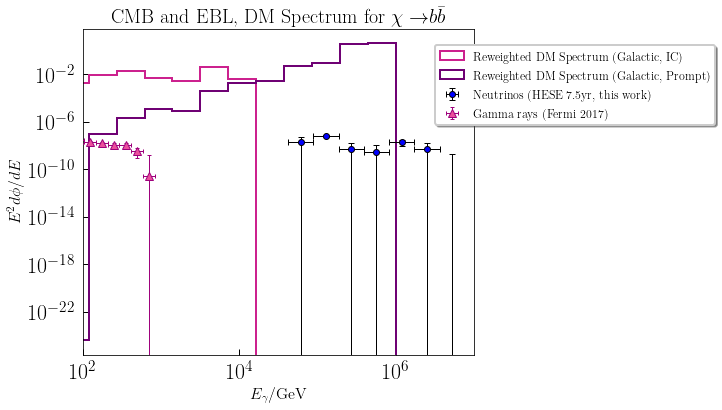

In [72]:
MakeGammaDMAttPlot(file_galactic_ebl,file_galactic_ebl_IC,weights_final_galactic,weights_final_ICgalactic,2*10**6,5)

In [ ]:
MakeGammaDMAttPlot(file_galactic_cmb,file_galactic_cmb_IC,weights_final_galactic_cmb,weights_final_ICgalactic_cmb,2*10**6,5)

(7730593,)
(0,)


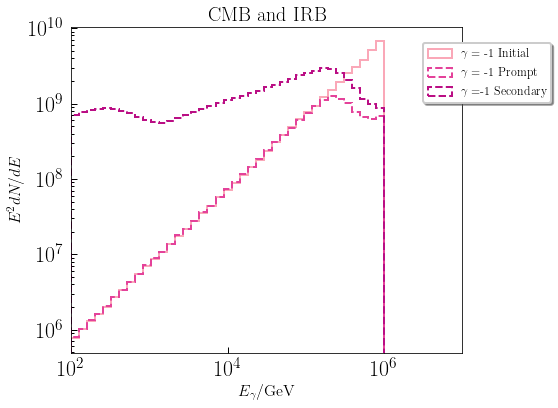

In [81]:
MakeInjPlot(file_galactic_ebl_IC,file_galactic_ebl,-1,True,False)

(777717,)


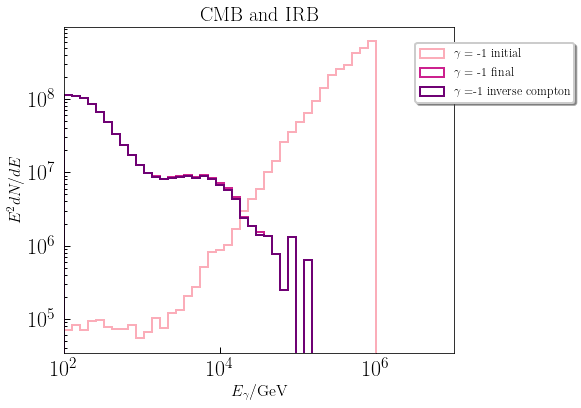

In [30]:
MakeInjPlot(file_extragalactic_ebl,-1,True,True)

<Figure size 504x432 with 0 Axes>

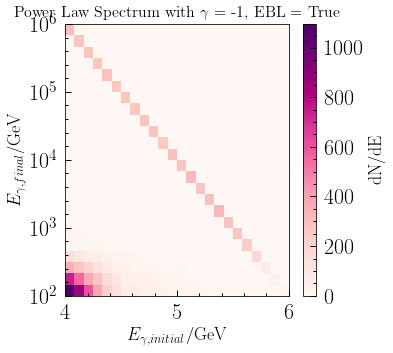

In [710]:
Make2DPowerLawPlot(file_galactic_ebl,-1,True)

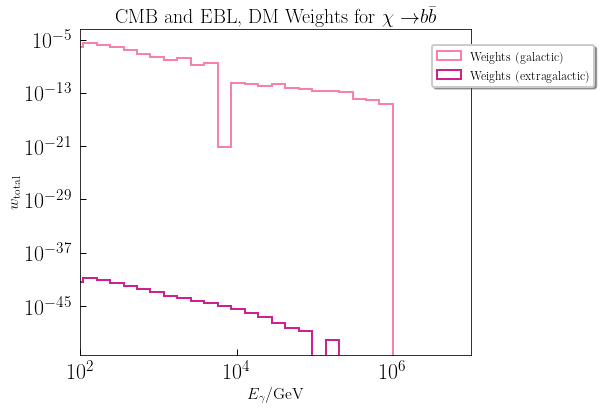

In [650]:
MakeWeightsPlot(file_galactic_ebl,file_extragalactic_ebl,weights_final_galactic,weights_final_extragalactic,2*10**6,5,True)

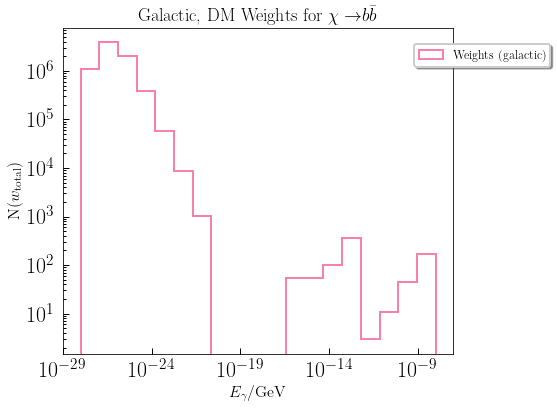

In [36]:
MakeWeightsHistPlot(weights_final_galactic,2*10**6,5,np.logspace(-28,-8,20),False)

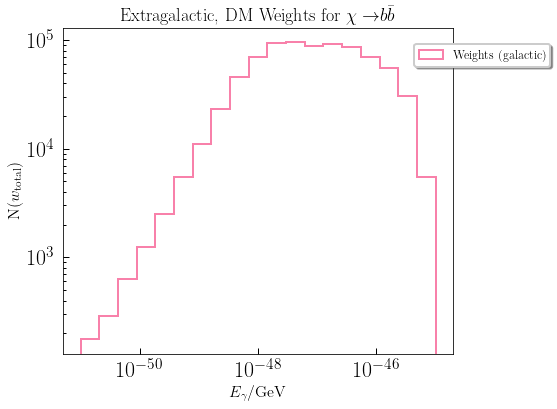

In [687]:
MakeWeightsHistPlot(weights_final_extragalactic,2*10**6,5,np.logspace(-51,-45,20),True)

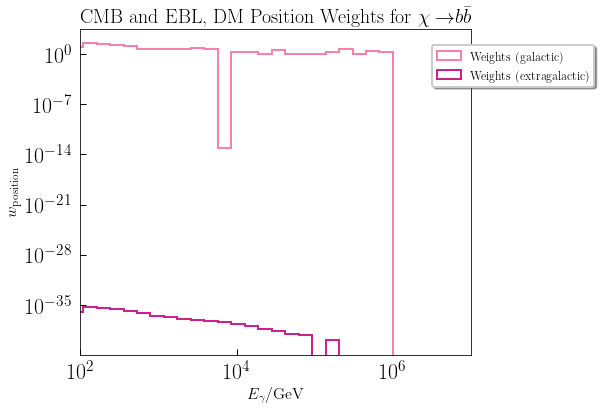

In [649]:
MakePositionWeightsVEnergyPlot(file_galactic_ebl,file_extragalactic_ebl,weights_r,weightsEG_r,2*10**6,5,True)

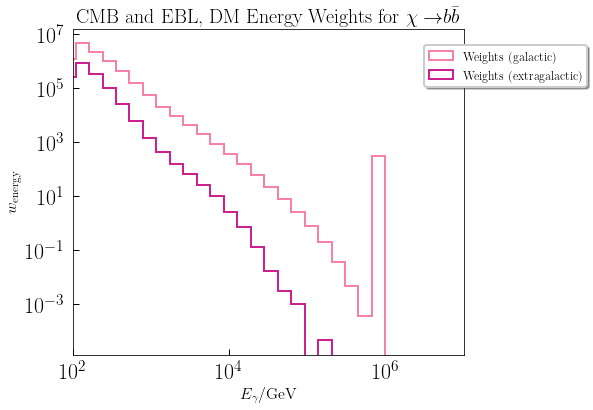

In [34]:
MakeEnergyWeightsVEnergyPlot(file_galactic_ebl,file_extragalactic_ebl,weights_energies,weightsEG_energies,2*10**6,5,True)

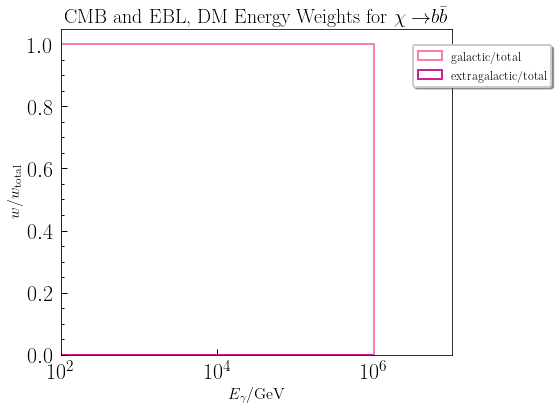

In [631]:
MakeWeightsRatioPlot(file_galactic_ebl,file_extragalactic_ebl,weights_final_galactic,weights_final_extragalactic,2*10**6,5,True)

In [56]:
print(weights_final_galactic)

[6.53245785e-24 1.26535540e-30 2.39248219e-30 ... 2.86331992e-32
 2.48641412e-31 4.59159987e-33]


In [125]:
print(np.histogram(np.array([xx[3] for xx in file_extragalactic_ebl if xx[2] == 22]),weights = weights_final_extragalactic)[0])

[2.27300998e-40 8.75548024e-47 2.81381105e-48 4.63312805e-49
 9.81123498e-50 1.08152624e-49 2.37492931e-50 0.00000000e+00
 0.00000000e+00 8.04491995e-51]


In [48]:
np.shape(file_galactic_ebl)

(1639493, 9)

4.0028463787498594e-13
1.300769456960941e-42
[1.56020329e-27 3.63940961e-27 3.63940961e-27 ... 4.23329454e-27
 1.76070037e-27 4.23329454e-27]


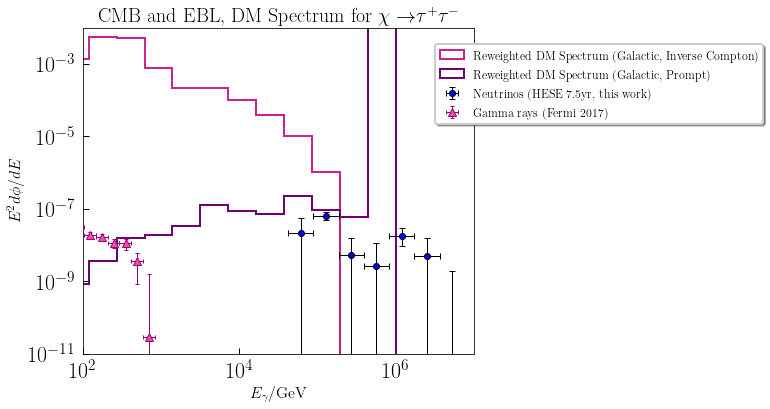

In [37]:
MakeGammaDMAttPlot(file_galactic_ebl,file_extragalactic_ebl,weights_final_galactic,weights_final_extragalactic,2*10**6,15)

4.0028463787498594e-13
1.300769456960941e-42
[1.56020329e-27 3.63940961e-27 3.63940961e-27 ... 4.23329454e-27
 1.76070037e-27 4.23329454e-27]


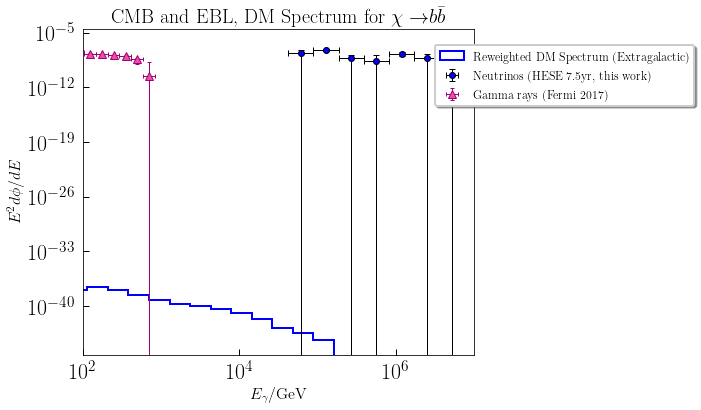

In [26]:
MakeGammaDMAttEGPlot(file_galactic_ebl,file_extragalactic_ebl,weights_final_galactic,weights_final_extragalactic,2*10**6,5)

[3.49649242e-27 1.27409070e-26 8.40670141e-27 ... 2.39645213e-27
 1.58122632e-27 6.57659358e-28]
[3.06938077e-32 1.84961683e-31 1.63777945e-26 ... 2.39645213e-27
 1.58122632e-27 6.57659358e-28]
[3839602       4       2       1       2       0       1       1       2
       1]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25520724e-17
 2.57314603e-10 2.16593384e-17 8.18326563e-18 1.95320335e-09
 1.66130169e-19 7.05175130e-20 3.71676135e-20 8.13920201e-09
 5.69608323e-21 9.12157159e-09 1.19289602e-08 6.33263093e-22
 7.69520592e-23 1.26820399e-23 6.63771601e-10]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25520724e-17
 4.22642898e-17 2.16593376e-17 8.18326019e-18 1.61578309e-18
 1.66128077e-19 7.05095803e-20 3.71498302e-20 2.19855664e-20
 5.69707101e-21 4.06545196e-21 9.26332514e-22 6.20359037e-22
 6.50613771e-23 2.66592224e-24 1.55464151e-18]
4.0028463787498594e-13
1.2978399904351828e-42
[3.06938077e-32 1.84961683e-31 1.63777945e-26 ... 2.39645213e-27
 1.58122632e-27 6.57659358e-28

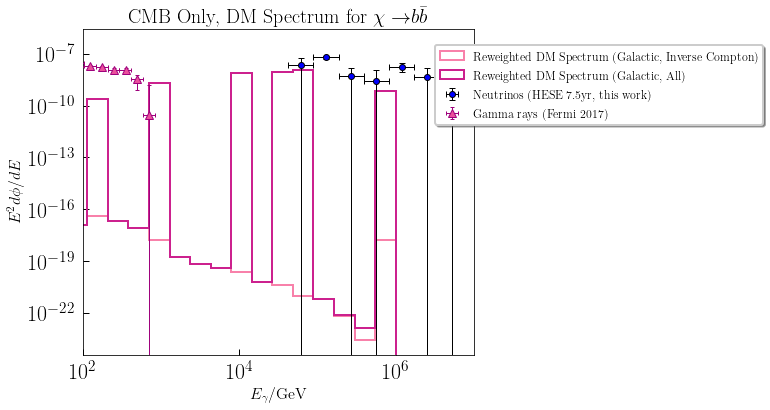

In [89]:
MakeGammaDMAttPlot(file_galactic_cmb,file_extragalactic_cmb,weightsCMB_final_galactic,weightsCMB_final_extragalactic,2*10**6,5,False)

In [ ]:
MakeGammaDMAttPlot(file_galactic_cmb,2*10**6,5)

### CRPropa Histograms

In [260]:
def MakePositionPlot(file,irb = True):


    if irb == True:
        string = "CMB and IRB"
    else: string = "CMB Only"
        
    photo_positions_initial = np.array([xx[6] for xx in file if xx[2] == 22])
    
    
    # make the figure 
    
    fig = plt.figure(figsize=(7,6))
    cm = mpl.pyplot.get_cmap('RdPu')
    color_min = 0.1
    color_max = 0.9
    color_range = color_max-color_min
    colors = [cm(color_range*i/(8-1)+color_min) for i in range(8)]
    
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = False, color = colors[3],label = r"Initial Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_injected)
    #plt.hist(x,bins = np.logspace(2,6,300),histtype = "step",lw = 2, density = True, color = colors[5],label = r"Attenuated Spectrum for $\gamma =$ {gamma}".format(gamma = gamma),weights = file_attenuated)
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum/(x**(gamma)*np.exp((-x/(10**8)))))*file_attenuated)
    plt.hist(photo_positions_initial,
             histtype="step", lw = 2, density = False, color = colors[3],label = r"Positions at source")
    #plt.hist(photo_energies_trajectories, bins = np.logspace(1,3,10),
    #         histtype="step", lw = 2, density = True, color = colors[6],label = r"Original Distribution")
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum/(x**(gamma)*np.exp((-x/(10**8)))))*file_attenuated)
    #plt.hist(x,bins = np.logspace(1,6,300),histtype = "step",lw = 2,density = False,color = colors[7],label = r"Reweighted DM Spectrum",weights = (spectrum*x**2/(file_injected))*file_attenuated)
    #plt.hist(x, bins = np.logspace(1,6,300),histtype="step", lw = 2, density = False,color ='orange',label = r"Initial DM Spectrum \par from HDMSpectra",weights = spectrum)
    
    plt.legend(bbox_to_anchor=(.90, .95), loc='upper left', borderaxespad=0.,frameon = True,shadow = True)
    #plt.ylim(10**21,10**26)
    #plt.semilogy()
    #plt.semilogx()
    #plt.xlim(1e1,1e3)
    #plt.ylim(1e-15,1e-6)
    #plt.ylim(1e2,1e6)
    plt.title(string+r",Positions at Source (Mpc)",fontsize = 16)
    plt.ylabel(r"Number of Events",fontsize = 16)
    #plt.title(r"CMB and IRB, DM Spectrum for $\chi \rightarrow$"+state,fontsize = 20)
    plt.savefig("/Users/barbaraskrzypek/Documents/DMPositions){irb}.pdf".format(irb = irb),dpi = 400,bbox_inches = "tight")
    
    #return rw

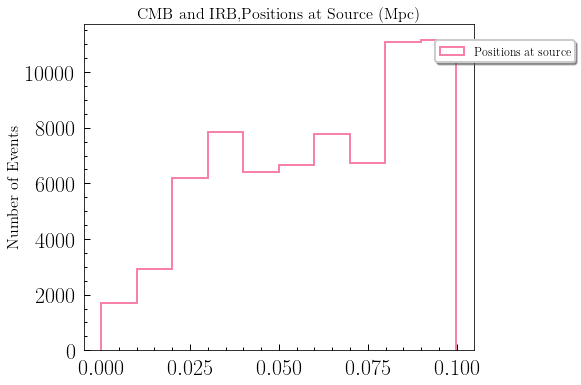

In [289]:
MakePositionPlot(file_galactic_ebl,True)

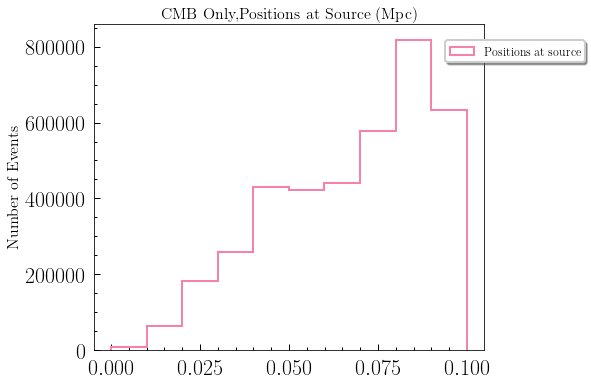

In [262]:
MakePositionPlot(file_galactic_cmb,False)

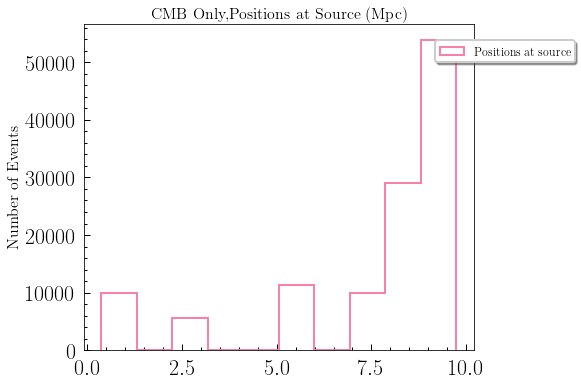

In [316]:
MakePositionPlot(file_extragalactic_cmb,False)

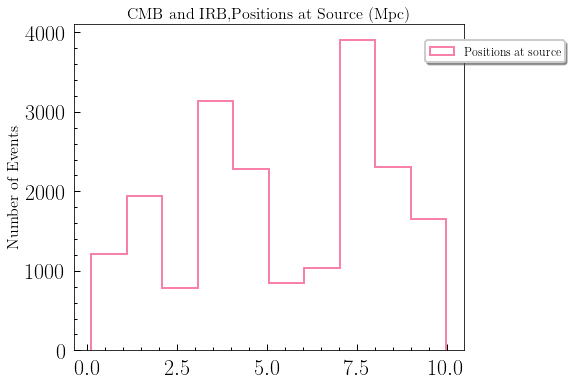

In [291]:
MakePositionPlot(file_extragalactic_ebl,True)